In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader as loader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.optim.lr_scheduler import (LambdaLR, CosineAnnealingLR, ReduceLROnPlateau,ChainedScheduler)
import matplotlib.pyplot as plt

In [55]:
device= torch.device("cuda" if torch.cuda.is_available() else"cpu")
#device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

transform=transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

train_data=datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data=datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader=loader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader=loader(test_data, batch_size=128, shuffle=True, num_workers=2)

model=models.resnet18(pretrained=True)
model.fc=nn.Linear(model.fc.in_features,10)
model=model.to(device)
criterion = nn.CrossEntropyLoss()

model

cuda
Files already downloaded and verified
Files already downloaded and verified


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [99]:
#옵티마이저 세팅
from qhoptim.pyt import QHAdam
lr=1e-4
optim_adamW=optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4, betas=(0.9,0.999), eps=1e-8)

optim_radam=optim.RAdam(model.parameters(), lr=lr, betas=(0.9,0.999), eps=1e-8, weight_decay=0)

optim_qha=QHAdam(model.parameters(), lr=lr, nus=(0.7,1.0),betas=(0.995,0.999),eps=1e-8,weight_decay=0)

In [107]:
#스케줄러 연결
from torch.optim.lr_scheduler import (
    LambdaLR, CosineAnnealingLR, ReduceLROnPlateau, ChainedScheduler,SequentialLR, StepLR
)
total_warmup_step=500
warmup_epochs = 5   # 처음 5 에폭 동안만 워밍업 적용
main_epochs   = 20  # 이후 20 에폭 동안 메인 스케줄러 적용

def warmup(step):
    return min((step+1)/total_warmup_step,1.0)

warmup_sched= LambdaLR(optim_adamW, lr_lambda=warmup)

cosine_sched=CosineAnnealingLR(optim_adamW, T_max=50, eta_min=1e-5)

plateau_sched=ReduceLROnPlateau(optim_adamW, mode='min', factor=0.5, patience=4)

#scheduler=ChainedScheduler([warmup_sched,cosine_sched,plateau_sched])
#scheduler_chain = ChainedScheduler([warmup_sched, cosine_sched])

scheduler = SequentialLR(
    optim_adamW,
    schedulers=[warmup_sched, cosine_sched, 
                StepLR(optim_adamW, step_size=30, gamma=0.1)],
    milestones=[warmup_epochs, warmup_epochs + main_epochs]
)


In [109]:
num_epoch=20

train_losses=[]
val_losses = []

for epoch in range(num_epoch):
    model.train()
    total_loss=0.0
    for data, (xb,yb) in enumerate(train_loader):
        xb,yb =xb.to(device), yb.to(device)
        optim_adamW.zero_grad()
        out=model(xb)
        loss=criterion(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optim_adamW.step()

        warmup_sched.step()
        total_loss+=loss.item()*xb.size(0)
    train_loss=total_loss/len(train_loader.dataset)
    train_losses.append(train_loss)


    model.eval()
    vrun = 0
    with torch.no_grad():
        for xb,yb in test_loader:
            xb,yb=xb.to(device),yb.to(device)
            vrun+=criterion(model(xb),yb).item()*xb.size(0)
    val_loss=vrun/len(test_loader.dataset)
    val_losses.append(val_loss)
        
    print(f"Epoch {epoch+1}/{num_epoch}  Train: {train_loss:.4f}, Val: {val_loss:.4f}")


Epoch 1/20  Train: 0.0106, Val: 0.7142
Epoch 2/20  Train: 0.0080, Val: 0.6386
Epoch 3/20  Train: 0.0067, Val: 0.6156
Epoch 4/20  Train: 0.0066, Val: 0.6217
Epoch 5/20  Train: 0.0060, Val: 0.6116
Epoch 6/20  Train: 0.0041, Val: 0.6682
Epoch 7/20  Train: 0.0077, Val: 0.5873
Epoch 8/20  Train: 0.0073, Val: 0.5411
Epoch 9/20  Train: 0.0055, Val: 0.6417
Epoch 10/20  Train: 0.0056, Val: 0.5665
Epoch 11/20  Train: 0.0076, Val: 0.5534
Epoch 12/20  Train: 0.0041, Val: 0.5763
Epoch 13/20  Train: 0.0051, Val: 0.5718
Epoch 14/20  Train: 0.0062, Val: 0.5807
Epoch 15/20  Train: 0.0046, Val: 0.5803
Epoch 16/20  Train: 0.0079, Val: 0.6523
Epoch 17/20  Train: 0.0050, Val: 0.6437
Epoch 18/20  Train: 0.0054, Val: 0.5592
Epoch 19/20  Train: 0.0038, Val: 0.5838
Epoch 20/20  Train: 0.0068, Val: 0.5668


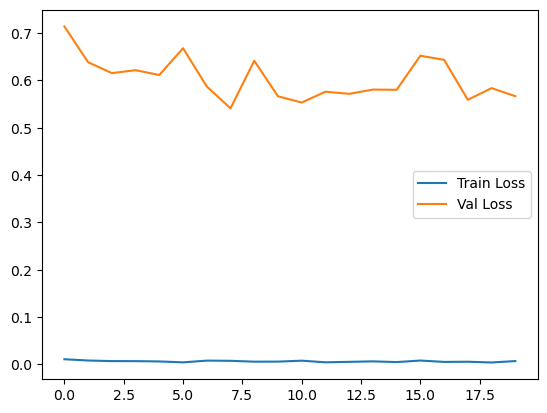

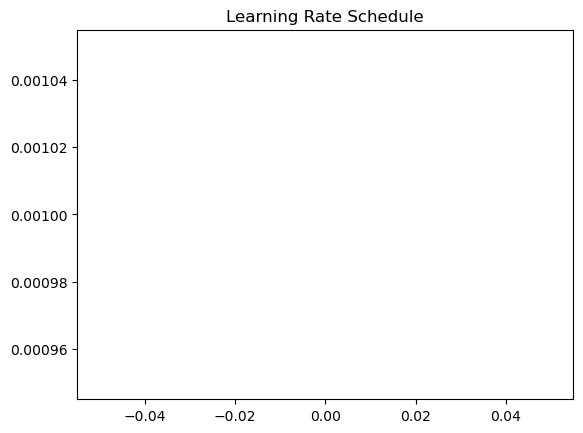

In [110]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.legend(); plt.show()

# 학습률 변화
lrs = [group['lr'] for group in optim_adamW.param_groups]
plt.plot(lrs)
plt.title("Learning Rate Schedule"); plt.show()
